In [189]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from misc_tools.print_latex import print_tex
env = gym.make('Blackjack-v1', sab=True)


actions = {0:'Stick', 1:'Hit!'}
rewards = {-1:'Loss', 0:'draw', 1:'Win!'}
done = False
state,_ = env.reset()
while not done:
    hand, hand_dealer, has_ace = state
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)[:4]
    hand_new, hand_dealer_new, has_ace_new = state
    print(f'{hand = }, {hand_dealer = }, {has_ace = }, {actions[action] = }\n',
          f'{hand_new = }, {hand_dealer_new = }, {has_ace_new = }, {rewards[reward] = }, {done = }\n')

hand = 12, hand_dealer = 3, has_ace = False, actions[action] = 'Hit!'
 hand_new = 19, hand_dealer_new = 3, has_ace_new = False, rewards[reward] = 'draw', done = False

hand = 19, hand_dealer = 3, has_ace = False, actions[action] = 'Stick'
 hand_new = 19, hand_dealer_new = 3, has_ace_new = False, rewards[reward] = 'Loss', done = True




State space $\{\text{current hand, dealers card, have usable ace}\}\in S


We examine a single episode consisting of $T$ time steps:

*   at time $i$ our agent was in state $s_i$, which may be visited at some other time $j$, so $s_i = s_j$
    $$(i,j) \in [0,1,\dots, T]$$
*   Trajectory:
    $$T = \{s_0,s_1,\dots,s_T\}$$
*   Rewards:
    $$R = \{r_0,r_1,\dots,r_{T-1}\}$$

*   reward $r_i$ is associated with transition $s_{i}\rightarrow s_{i+1}$ via action $a$
    $$r_i: s_{i}\overset{a}{\rightarrow} s_{i+1}$$
*   state $s_i$ has cumulative future reward  
    $$R(s_i) = \sum_i^{T-1} r_i$$

*   Thus value of an action $$q(s_i = s,a) = \sum_i^{T-1} r_i$$

We can get an average (estimated) reward for action-state pair $(a,s)$ by analyzing multiple episodes

*   $$\bar q(s,a) = \frac{1}{N_s} q^k(s,a)$$

In [190]:
env.step(0)

((19, 3, False), -1.0, True, False, {})

In [191]:

state, reward, done, info

((19, 3, False), -1.0, True, False)

In [192]:
print(env.action_space)

Discrete(2)


In [193]:
policy = np.zeros(( 32, 12, 2, 2)) # hand, card dealer, has ace, actions probs distr: [1,0] = stick, [0,1] =hit
hit_limit = 16
policy[:hit_limit,:,:,1] = 1              # less than 20 -> hit 100%
policy[hit_limit:,:,:,0] = 1 
vals = np.zeros(( 32, 12, 2))

In [194]:
def get_traj_N(N):
    trajs_all = []
    actions_all = []
    rewards_all = []
    for _ in range(N):
        
        state,_ = env.reset()
        trajs = [state]
        rewards = []
        actions = []
        while True:
            hand, hand_dealer, has_ace = state
            action = np.random.choice(np.arange(2), p = policy[hand,hand_dealer,int(has_ace)])
            state, reward, done, info = env.step(action)[:4]
            trajs.append(state)
            actions.append(action)
            rewards.append(reward)

            if done: break

        trajs_all.append(trajs)
        actions_all.append(actions)
        rewards_all.append(rewards)
    return trajs_all,actions_all,rewards_all



In [195]:
from collections import defaultdict
trajs_all,actions_all,rewards_all = get_traj_N(500_000)

visited_states = set()
for tr in trajs_all: visited_states.update(tr)

expected_vals = defaultdict(float)#{i:0 for i in visited_states}
num_visits = defaultdict(float)#{i:0 for i in visited_states}

def update_mean(arr_a_mean, arr_a_len, arr_b):
    return 1/(arr_a_len+len(arr_b)) * (arr_a_len*arr_a_mean + len(arr_b)*arr_b.mean())

for tr, ac, rw in zip(trajs_all,actions_all,rewards_all):
    for i in range(len(rw)):
        s = tr[i]
        rews = np.array(rw[i:])
        if num_visits[s] == 0:
            expected_vals[s] = rews.mean()
        else:
            expected_vals[s] = update_mean(expected_vals[s], num_visits[s], rews)

        num_visits[s] += 1

#num_visits, expected_vals        

In [199]:
for (hand, hand_dealer, has_ace ), val in expected_vals.items(): 
    vals[hand, hand_dealer, has_ace] = val

(10.0, 21.0)

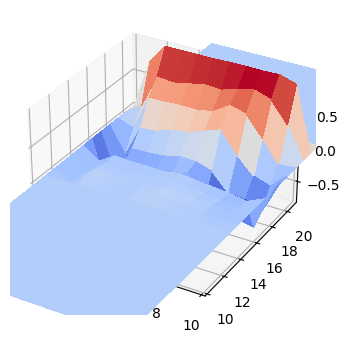

In [200]:
x, y = np.meshgrid(np.arange(12), np.arange(32))
from matplotlib import cm
fig, ax = plt.subplots(1,1, figsize = (10,3.3), layout='constrained',subplot_kw={"projection": "3d"})

surf = ax.plot_surface(x, y,vals[:,:,0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlim(0, 10)
ax.set_ylim(10,21)

In [198]:
ab = np.arange(16)
split = 15
a = ab[:split]; b = ab[split:]
ab.mean() == 1/(len(a)+len(b)) * (len(a)*a.mean() + len(b)*b.mean()), ab.mean() == update_mean(a.mean(), len(a), b)

(True, True)